<a href="https://colab.research.google.com/github/ZBW-P/Convolution_network_Resnet_performance_test/blob/main/Lab3_spec_decode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NYU CSCI-GA 3303 ECE-GY 9483 Fall 2025: Lab 3 Speculative Decoding**

---



Hey everyone, this lab focuses on LLM Speculative Decoding. The lab contains four parts, with a total of 100 points:

Tasks:
1. **Standard speculative decoding** (draft proposes K tokens; target verifies longest prefix; target adds a bridge token).
2. **Finetune** the small draft model with **LoRA**.
3. **Evaluation** uses a **multiple-choice QA dataset** (ARC-Easy) to compare accuracy across modes.
4. **(Bonus part) Pruning for Faster Speculative Decoding** experiments: attention **heads**, **layers**, and **tokens**.

> **Models**
> - Draft: `Qwen/Qwen3-0.6B-Instruct`  
> - Target: `Qwen/Qwen3-1.7B-Instruct` (or any compatible ~1.7–1.8B)


If you're using Colab, go to the settings menu (Runtime -> Change runtime type) and select GPU as the hardware accelerator. The best way to run your code is using Colab and it's free.

Same as Lab1, you need to solve two types of problems: coding and short-answer questions.

* **Coding: you only need to complete the section labeled as:**   
```
    ##############################################################################
    #TODO:
    ##############################################################################

    ##############################################################################
    #END OF YOUR CODE                              #
    ##############################################################################
```
* **Question Answering: questions start with a red dot "🔴", and you should write your answers in the following text block.**


***Please upload your ipynb file for Lab 3 to Brightspace. Name the file as "netid_lab_3.ipynb" and ensure it is submitted by November 16th at 11:59 PM.***



If you have any questions, feel free to ask me during my office  hour on Wednesday from 2 PM to 3 PM https://nyu.zoom.us/j/98317554792, or contact me at yh5961@nyu.edu.

## GPU Requirement

This assignment requires **CUDA support**. Please make sure to run it on a **local machine with a GPU** or on **Google Colab** with GPU enabled. We recommend using **Google Colab**, as it provides free access to GPUs.

If you are working on Colab, click the 'Connect' button in the top-right corner. Once connected, go to Runtime->Change runtime type and select GPU as the hardware accelerator.

Once you are connected to a GPU (either on local machine or Colab), you can run the following command to check the GPU on your machine.

In [1]:
! nvidia-smi

Thu Nov 13 21:23:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Initialization

Let's start with importing the necessary packages:

In [2]:
! pip install -U transformers accelerate datasets peft bitsandbytes evaluate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
  Attempting uninstall: peft
    Found existing installation: peft 0.17.1
    Uninstalling peft-0.17.1:
      Successfully uninstalled peft-0.17.1


# 🤗 Hugging Face Quick Tutorial

Before starting the lab section, here is a brief guide to help you **locate, load, and utilize** models from the Hugging Face Hub.

## 1. 🔍 Find Models on the Hub
Visit [**huggingface.co/models**](https://huggingface.co/models).  
You can search by keywords like:
- `Qwen2.5`, `LLaMA3`, `Gemma3` → model families  
- `instruct`, `chat`, `vl`, `pretrain` → model purposes  

**Tips:**
- Use filters on the left (Library, Task, License).  
- Read the model card for usage, requirements, and license details.

## 2. 💬 Common Model Suffixes

| Suffix | Meaning | Use |
|---------|----------|-----|
| `-pretrain` | Raw base model | Fine-tuning or research |
| `-instruct` | Instruction-tuned | Follows natural language instructions |
| `-chat` | Dialogue-tuned | Multi-turn chat tasks |
| `-think` | Reasoning-tuned | Step-by-step reasoning |
| `-vl` | Vision-language | Text + Image models |

## 3. ⚙️ Load a Model and Tokenizer

In [3]:
# Here provides a code snippet with apply_chat_template to show you how to load the tokenizer and model and how to generate contents.
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-1.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

**Key Notes:**
- `use_fast=True`: Faster Rust-based tokenizer  
- `pad_token = eos_token`: Fix padding for generation  
- `device_map="auto"`: Auto GPU/CPU placement  
- `torch_dtype`: Controls precision (`fp16`, `bf16`)  
- `model.eval()`: Enables inference mode  

## 4. 🚀 Generate Text
This will produce a short response from the model.

In [4]:
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [5]:
response

'A large language model (LLM) is an artificial intelligence system that can generate human-like text based on the input provided to it. These models are trained using vast amounts of data and have been developed in various fields such as natural language processing, computer vision, and speech recognition.\n\nThe key feature of LLMs is their ability to understand and generate complex sentences, paragraphs, and even entire documents with high accuracy. They learn from massive datasets containing millions or billions of words and use advanced algorithms to identify patterns and relationships between different pieces of information.\n\nSome examples of popular large language models include GPT-3, BERT, and T5. These models have revolutionized many industries by enabling more efficient communication, improved customer service, and enhanced decision-making processes. However, they also raise important ethical considerations around privacy, bias, and potential misuse of the technology.'

## 5. 📊 Find and Load Datasets

### 🔎 Find Datasets
Go to [**huggingface.co/datasets**](https://huggingface.co/datasets).  
Search by keywords like `sst2`, `alpaca`, `daily_dialog`, or filter by **task**, **language**, or **license**.

Each dataset page provides:
- Example usage code  
- Dataset splits (`train`, `validation`, `test`)  
- Size and license info

### 🧩 Load Dataset in Python


In [6]:
from datasets import load_dataset

# Load a public dataset
dataset = load_dataset("sst2")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

**Notes:**
- Supports many formats: `json`, `csv`, `parquet`, `text`, `imagefolder`  
- You can subset using slice syntax: `"train[:10%]"` or `"validation[:100]"`  
- Use `.map()` and `.filter()` to process samples efficiently.

# Question 1. Standard Speculative Decoding (40 Points)
### Goal

In this task, you will implement the core speculative decoding loop that connects a draft model and a target model.
The objective is to reproduce the standard speculative decoding process, including proposal generation, verification, and bridging, while measuring how efficiently the system produces correct tokens compared to standard autoregressive decoding.

### Background
<p align="center">
  <img src="https://github.com/HuYunhai-Alex/lab3_sd/blob/main/sd.png?raw=true" alt="cnn" width="400"/>
</p>

Speculative decoding (SD) accelerates generation by letting a **small draft model** propose multiple tokens, which are then **verified in parallel** by a larger target model.

#### 1. Overview
Instead of having the target model generate every token sequentially, SD allows it to **reduce the decoding latency** when the draft’s predictions are correct.

#### 2. Three Main Steps
1. **`draft_propose_k`** — The **Draft LM** quickly generates `K` candidate tokens (e.g., 1, 2, 3, 4).  
   → Fast proposal step.

2. **`target_verify_prefix`** — The **Target LM** checks these tokens in parallel.  
   - If all are correct ✅, they are accepted directly.  
   - If a mismatch occurs ❌, decoding falls back to that point.  
   → Verification step.

3. **`target_bridge_one`** — The **Target LM** then generates one new token (e.g., token 5) as a bridge for the next round.  
   → Continue decoding from here.

#### 3. Speed Benefit
Since the target model verifies multiple tokens per step instead of generating them one by one:

$$
T_{tot} = NT_{p,2} + T_{val} < NT_{p,1}
$$

Where:
- $ NT_{p,1} $: Time for the target model to generate tokens sequentially.  
- $ NT_{p,2} $: Time for the draft model to propose multiple tokens.  
- $ T_{val} $: Time for the target model to verify them.


## Learning Objectives

By completing this question, you will:

- Understand the speculative decoding pipeline
- Implement modular components (draft_propose_k, target_verify_prefix, target_bridge_one) that reproduce the standard speculative decoding logic.
- Measure how the number of proposed and accepted tokens affects speed and accuracy.
- Learn to record decoding statistics such as acceptance rate, proposed tokens, and verify calls for empirical evaluation.
- Develop intuition for system-level optimization, how small, fast draft models can serve as effective approximations for large models during inference.


In [7]:
# Environment settings
import os, math, time, random, re
from dataclasses import dataclass
from typing import List, Dict, Tuple
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

INSTRUCTOR_MODE = True  # True: show solutions; False: mask TODOs for students
DTYPE = torch.bfloat16 if torch.cuda.is_available() else torch.float32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DRAFT_MODEL_ID  = os.environ.get('DRAFT_MODEL_ID',  'Qwen/Qwen2.5-0.5B-Instruct')
TARGET_MODEL_ID = os.environ.get('TARGET_MODEL_ID', 'Qwen/Qwen2.5-1.5B-Instruct')

def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

## 1.1 Load Models and Tokenizers using Hugging Face (10 pts)

Learn how to correctly load a pretrained tokenizer and causal language model from the Hugging Face Transformers library for text generation or fine-tuning.

Implement load_model_and_tokenizer(model_id, device, dtype) to load both the tokenizer and causal language model using AutoTokenizer and AutoModelForCausalLM, use device_map='auto' and torch_dtype=dtype for proper device and precision handling, call model.eval() for inference mode, and return both the tokenizer and model.

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def load_model_and_tokenizer(model_id: str, device=DEVICE, dtype=DTYPE):
    # ##############################################################################
    # ###### TODO:Function: load_model_and_tokenizer ###############################
    # Understand how to:
    # 1. Load a tokenizer from Hugging Face.
    # 2. Load the corresponding model for causal language modeling (text generation).
    # 3. Set padding and device/dtype properly for inference or fine-tuning.
    # ##############################################################################
    model_name = model_id

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
        device_map='auto'
    )
    tok=AutoTokenizer.from_pretrained(model_name)

    if tok.pad_token is None:
      tok.pad_token = tok.eos_token


    # === Example Usage =====================================================
    # You can replace these IDs with your own model choices from Hugging Face,
    # e.g., "Qwen/Qwen2.5-0.5B-Instruct" or "meta-llama/Llama-3-8B-Instruct"
    # ======================================================================
    model.eval()
    return tok, model



draft_tok, draft_model  = load_model_and_tokenizer(DRAFT_MODEL_ID)
target_tok, target_model = load_model_and_tokenizer(TARGET_MODEL_ID)

# Print confirmation to verify successful loading
print('Loaded draft:', DRAFT_MODEL_ID)
print('Loaded target:', TARGET_MODEL_ID)


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loaded draft: Qwen/Qwen2.5-0.5B-Instruct
Loaded target: Qwen/Qwen2.5-1.5B-Instruct


## 1.2 Implement Speculative Decoding: Core Steps (30 pts)
In this assignment, you will **complete the speculative decoding algorithm** that connects a small *draft model* and a large *target model* to accelerate text generation.

### 🎯 Goal
You will fill in the two missing parts in the provided code (`TODO` sections):

---

### **Step A — Draft Proposal**
- Run the **drafter model** for `gamma` steps.  
- Convert logits to probabilities using the provided `logits_processor`.  
- Sample (greedy) one token per step and append it to `input_ids`.  
- Save each step’s probability distribution in the tensor `q`.

---

### **Step B — Target Verification (Rejection Sampling)**
- Run the **target model** on the proposed drafts.  
- Compute element-wise ratios `p / q` between target and draft probabilities.  
- Draw random numbers `r[i]` and accept consecutive tokens as long as  
  `r[i] <= (p_prob / q_prob)` for that token.  
- Stop at the first rejection — the accepted length `n` is how many tokens are kept.

In [9]:
import torch
from torch.nn import Module
from typing import List, Tuple
from torch.nn import functional as F

class GreedyProcessor():
    """Greedy: Most probable token."""
    def __call__(self, logits):
        proc = self._process(logits)
        return F.softmax(proc, dim=-1)

    def _process(self, logits):
        return logits

    def sample(self, probs):
        return torch.argmax(probs, dim=-1).unsqueeze(-1)


def max_fn(x):
    """
    Max function.
        x: input tensor.
    Returns:
        tensor norm(max(0, x)).
    """
    x_max = torch.where(x > 0, x, torch.zeros_like(x))
    x_max_sum = torch.sum(x_max, dim=-1, keepdim=True)
    return x_max / x_max_sum


@torch.no_grad()
def speculative_generate(
    inputs: List[int],
    drafter: Module,
    target: Module,
    tokenizer = None,
    gamma: int = 5,
    logits_processor = GreedyProcessor(),
    max_gen_len: int = 40,
    eos_tokens_id: int | List[int] = 1,
    pad_token_id: int = 0,
    use_cache: bool = False,
    skip_sample_adjustment: bool = False,
    first_target: bool = True,
    debug: bool = False,
) -> Tuple[List[int], float]:
    """
    Generate text sequence using the speculative decoding algorithm.
    Implementation of Speculative Decoding. (https://arxiv.org/pdf/2211.17192.pdf)

    Args:
        inputs (List[int]): input sequence of batch size 1.
        drafter (Module): drafter model.
        target (Module): target model.
        tokenizer: tokenizer (used for debugging).
        gamma (int): number of drafts generated by the drafter at each step.
        logits_processor (LogitsProcessor): logits processor for sampling.
        max_gen_len (int): maximum length of the generated sequence.
        eos_tokens_id (int or List[int]): end token id (could be multiple).
        pad_token_id (int): pad token id.
        use_cache (bool): whether to use cache.
        skip_sample_adjustment (bool): whether to skip the sample adjustment step when some drafts are discarded.
        first_target (bool): whether to run the target model before the speculative algorithm.
        debug (bool): debug mode.

    Returns:
        List[int]: generated sequence.
        float: acceptance rate (number of accepted drafts divided by the number of total drafts).

    Note: This generation methods only works for decoder-only models.
    Note bis: The drafter and target models should output the same logits shape.
    Note ter: NgramModels are currently not supported.
    """

    drafter_cache, target_cache = None, None

    list_tokens_id = eos_tokens_id if isinstance(eos_tokens_id, list) else [eos_tokens_id]
    stop_tokens = torch.tensor(list_tokens_id, dtype=torch.long, device=target.device).unsqueeze(1)

    drafts_accepted, drafts_speculated = .0, .0

    vocabulary_size = target.config.vocab_size

    # prepare input tensor
    prompt_len = len(inputs)
    max_seq_length = target.config.max_position_embeddings if hasattr(target.config, 'max_position_embeddings') else (target.config.max_context_length if hasattr(target.config, 'max_context_length') else 1024)
    total_len = min(max_seq_length, prompt_len + max_gen_len)
    input_ids = torch.full((1, total_len), pad_token_id, dtype=torch.long, device=target.device)
    input_ids[0, :prompt_len] = torch.tensor(inputs, dtype=torch.long, device=target.device)

    current_position = prompt_len

    if first_target:
        # run the target model before the speculative algorithm. Allows to prefill the kvcache and get a first token.
        Mp = target(
            input_ids=input_ids[..., :current_position],
            use_cache=use_cache,
        )
        p_p = logits_processor(Mp.logits[..., -1, :])
        t = logits_processor.sample(p_p)
        input_ids[0, current_position] = t
        current_position += 1

        if torch.isin(t, stop_tokens):
            return input_ids[0, prompt_len:current_position].tolist(), 0


    while current_position < total_len:
        corrected_gamma = min(gamma, total_len - current_position - 1)
        q = torch.zeros((1, corrected_gamma, vocabulary_size), device=target.device)

        input_ids = input_ids.to(drafter.device)

        # generate gamma drafts
        ##############################################################################
        # TODO:
        # Step A: Drafter forward passes and candidate sampling.
        # - For k in [0..corrected_gamma-1]:
        #   1) Run drafter on the prefix ending at current_position + k - 1.
        #   2) Convert logits to probabilities with `logits_processor` (softmax + any transforms).
        #   3) Save the per-step probabilities to q[0, k] (on target device for later comparison).
        #   4) Sample (greedy here) a candidate token xi from those probabilities.
        #   5) Place xi into input_ids at position current_position + k to form the draft chain.
        ##############################################################################
        for k in range(0,corrected_gamma):
          out_draft = drafter(
              input_ids=input_ids[..., :current_position + k],
              use_cache=use_cache
          )
          logits = out_draft.logits[..., -1, :]
          probs = logits_processor(logits)
          q[0,k,:] = probs[0,:].to(target.device)
          xi = logits_processor.sample(probs)
          input_ids[0, current_position + k] = xi


        ##############################################################################
        # END OF YOUR CODE
        ##############################################################################
        drafts_speculated += corrected_gamma
        input_ids = input_ids.to(target.device)

        # run target model on drafts and get logits of the previous tokens plus one more token
        Mp = target(
            input_ids=input_ids[..., :current_position + corrected_gamma],
            past_key_values=target_cache,
            use_cache=use_cache,
        )
        target_cache = Mp.past_key_values
        draft_logits = Mp.logits[..., current_position - 1:current_position + corrected_gamma - 1, :] # [1, corrected_gamma, vocab_size]
        p = logits_processor(draft_logits) # [1, gamma, vocab_size]

        # compute the last accepted draft position (rejection sampling)
        ##############################################################################
        # TODO:
        # Step B: Rejection test to find how many draft tokens to accept.
        # - Draw uniform random r[i] for each draft step i.
        # - Compute acceptance ratio `fractions = p / q` (element-wise).
        # - Accept consecutive draft tokens while:
        #       r[i] <= (p_prob at chosen token) / (q_prob at chosen token)
        #   The first failure index `i` is the cut `n` (number accepted so far).
        # - If all pass, `n = corrected_gamma`.
        ##############################################################################
        r = torch.rand((corrected_gamma,), device=target.device)
        p = p.to(target.device)
        accepted = 0
        for k in range(corrected_gamma):
          token_id = int(input_ids[0, current_position + k].item())
          ratio = p[0, k, token_id] / (q[0, k, token_id] + 1e-9)
          if r[k] <= ratio:
            accepted += 1
          else:
            break
        n = accepted


        ##############################################################################
        # END OF YOUR CODE
        ##############################################################################

        drafts_accepted += n

        # check if the end token is in the drafts
        stop_locations = torch.nonzero(torch.eq(input_ids[..., current_position:current_position + n], stop_tokens))
        if stop_locations.shape[0] > 0:
            stop_location = stop_locations[0, 1].item()
            return input_ids[0, prompt_len:current_position + stop_location + 1].tolist(), drafts_accepted / drafts_speculated

        if n == corrected_gamma:
            p_p = Mp.logits[..., current_position + corrected_gamma - 1, :]
            p_p = logits_processor(p_p)
        else:
            if not skip_sample_adjustment:
                p_p = max_fn(p[..., n, :] - q[0, n, :])
            else:
                p_p = p[..., n, :]

        x = logits_processor.sample(p_p)

        input_ids[0, current_position + n:current_position + corrected_gamma] = pad_token_id
        input_ids[0, current_position + n] = x

        current_position += n + 1

        if torch.isin(x, stop_tokens):
            return input_ids[0, prompt_len:current_position].tolist(), drafts_accepted / drafts_speculated

    return input_ids[0, prompt_len:].tolist(), drafts_accepted / drafts_speculated

print('speculative decoding is ready.')


speculative decoding is ready.


In [10]:
def main():
    global target_model, draft_model, target_tok, draft_tok

    prompt = "Once upon a time in a distant galaxy"

    tokenized = target_tok(prompt, return_tensors="pt").input_ids[0].tolist()
    print("\nRunning speculative decoding...")
    output_ids, accept_rate  = speculative_generate(tokenized, draft_model, target_model, target_tok, gamma=5)

    print("\n=== Generated Text ===")
    print(target_tok.decode(output_ids, skip_special_tokens=True))
    print("\n=== Decode Stats ===")
    print(f"Acceptance rate : {accept_rate:.2%}")

if __name__ == "__main__":
    main()


Running speculative decoding...

=== Generated Text ===
, there was a planet named Zephyria. The planet was known for its unique ecosystem, which was home to a variety of species. One of the species, the Zephyrian Zephyrs

=== Decode Stats ===
Acceptance rate : 86.11%


# Question 2. Finetune a Small Model with LoRA (30 pts)

### 🎯 Goal
Build a **minimal and reproducible LoRA fine-tuning pipeline** using a small instruction model and a toy dataset (~50 examples).  
Your pipeline should:
1. Prepare and format data properly for instruction-style fine-tuning.  
2. Apply **label masking** so only **assistant responses** contribute to the loss.  
3. Wrap the base model with **LoRA adapters** and fine-tune only those parameters.  
4. Evaluate with a simple sanity check (e.g., prompt → short answer).

---

### 🧠 Background

#### 🔸 Supervised Fine-Tuning (SFT)

SFT aligns a base model with human-style instructions.

- **Input:** `(user input, assistant output)`
- **Objective:** minimize cross-entropy **only on assistant tokens**.

During training:

- **Mask (-100):**  
  The model outputs **logits** — predicted probability distributions over the vocabulary for each token position.  
  These logits are compared with the **labels**, which are the ground-truth token IDs from the training data.  
  However, in a multi-turn conversation, tokens from the *user* parts are **not targets**, we don’t want the model to predict what the user said.  
  Therefore, these tokens are replaced with `-100` in the labels, telling  
  `CrossEntropyLoss(ignore_index=-100)` to skip them during loss computation.  
  As a result, the model learns **only from the assistant’s output tokens**.

  `-100` is a special PyTorch hint meaning “ignore this position.”  
  It ensures that no gradient is calculated for masked tokens, focusing optimization solely on assistant responses.

- **Shift:**  
  Since the model is autoregressive, it predicts the **next token** at each step.  
  The prediction (logit) for one position is compared with the *next* token as the label,  
  this “shift” ensures proper alignment between predicted and target tokens.

**Example:**  
For a conversation:  
> User: Hi!  
> Assistant: Hello there!

The model:
- Masks out the *User* tokens with `-100` so they don’t contribute to loss.  
- Learns to predict `"there!"` given `"Hello"`, and `"Hello"` given `"Assistant:"`,  
  by shifting the labels one token ahead and comparing logits (predictions) to labels (ground truth).


<p align="center">
  <img src="https://github.com/HuYunhai-Alex/lab3_sd/blob/main/lora.png?raw=true" alt="cnn" width="400"/>
</p>

#### 🔸 Low-Rank Adaptation (LoRA)
LoRA injects small trainable matrices **A** and **B** into existing linear layers (like Q, K, V, and output projections).  
- The base model weights remain **frozen**.  
- Only a few low-rank parameters (rank *r*) are updated.  
- This makes training **faster, cheaper, and memory-efficient**, while maintaining performance.

---

### 🧩 Implementation Steps

1. **Data Preparation**
   - Build a tiny dataset with 50 instruction–answer pairs.
   - Convert each example into a single sequence:  
     `[SYSTEM] ... [USER] ... [ASSISTANT] ...`
   - Apply label masking so only assistant tokens are trained.

2. **Model Wrapping**
   - Load a small instruction model (e.g., `Qwen2.5-0.5B-Instruct` or `TinyLlama-1.1B-Chat`).
   - Attach LoRA adapters to attention and MLP layers.

3. **Training**
   - Use standard causal LM loss with masked labels.
   - Freeze base weights; train only LoRA parameters.
   - Log training loss and save LoRA checkpoints.

4. **Evaluation**
   - Generate sample responses for sanity check.
   - Optionally compute a simple metric (accuracy or BLEU) on the toy dataset.

---

### ✅ Learning Objectives
- Understand how **SFT** focuses learning on assistant outputs via label masking.  
- Learn how **LoRA** enables lightweight fine-tuning by updating low-rank adapters.  
- Practice implementing a **clean, stable, and reproducible** training pipeline with logging and checkpoints.


In [13]:
!pip install trl
!pip install bitsandbytes
!pip install peft accelerate
!pip install trackio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.0/875.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 120.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


## 2.1 HumanEval SFT Data Generation Script (10 pts)

This script converts the **OpenAI HumanEval** dataset into a supervised fine-tuning (SFT) JSONL format.  
Each entry contains a two-turn conversation between a *user* and an *assistant*:

- **user**: The HumanEval problem prompt (Python function signature and docstring).  
- **assistant**: The model’s generated completion, produced deterministically (`do_sample=False`, `temperature=0.0`).

The output file `humaneval_sft.jsonl` contains lines like:
```json
{"id": "humaneval_0", "conversations": [{"from": "user", "value": "<prompt>"}, {"from": "assistant", "value": "<completion>"}]}


In [14]:
from datasets import load_dataset
import json

def main():
  # ====== Config ======
  global target_model, target_tok
  OUT_PATH = "./humaneval_sft.jsonl"
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  # ====== Load dataset ======
  dataset = load_dataset("openai_humaneval", split="test[:50]")
  # ====== Generate SFT data ======
  records = []
  for i, ex in enumerate(dataset):
      user_input = ex["prompt"].strip()
      inputs = target_tok(user_input, return_tensors="pt").to(DEVICE)
      with torch.no_grad():
          output = target_model.generate(
              **inputs,
              max_new_tokens=256,
              do_sample=False,
              temperature=0.0
          )
      completion = target_tok.decode(
          output[0][inputs["input_ids"].shape[1]:],
          skip_special_tokens=True
      ).strip()
      # ====== Build conversation record ======
      ##############################################################################
      # TODO: Construct a JSON record for each sample.
      # Each record should have:
      #   - a unique "id" like "humaneval_0"
      #   - a "conversations" list with two turns:
      #       1. {"from": "user", "value": user_input}
      #       2. {"from": "assistant", "value": completion}
      # Hint: Follow the SFT-style format used by LLaMA Factory / OpenRLHF.
      ##############################################################################
      record = {
          "id": f"humaneval_{i}",
          "conversations": [
              {"from": "user", "value": user_input},
              {"from": "assistant", "value": completion}
          ]
      }
      records.append(record)


      ##############################################################################
      # END OF YOUR CODE
      ##############################################################################
      print(f"✓ processed {i+1}/{len(dataset)}")
  # ====== Save ======
  with open(OUT_PATH, "w", encoding="utf-8") as f:
      for r in records:
          f.write(json.dumps(r, ensure_ascii=False) + "\n")
  print(f"\nSaved {len(records)} samples to {OUT_PATH}")


if __name__ == "__main__":
    main()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ processed 1/50
✓ processed 2/50
✓ processed 3/50
✓ processed 4/50
✓ processed 5/50
✓ processed 6/50
✓ processed 7/50
✓ processed 8/50
✓ processed 9/50
✓ processed 10/50
✓ processed 11/50
✓ processed 12/50
✓ processed 13/50
✓ processed 14/50
✓ processed 15/50
✓ processed 16/50
✓ processed 17/50
✓ processed 18/50
✓ processed 19/50
✓ processed 20/50
✓ processed 21/50
✓ processed 22/50
✓ processed 23/50
✓ processed 24/50
✓ processed 25/50
✓ processed 26/50
✓ processed 27/50
✓ processed 28/50
✓ processed 29/50
✓ processed 30/50
✓ processed 31/50
✓ processed 32/50
✓ processed 33/50
✓ processed 34/50
✓ processed 35/50
✓ processed 36/50
✓ processed 37/50
✓ processed 38/50
✓ processed 39/50
✓ processed 40/50
✓ processed 41/50
✓ processed 42/50
✓ processed 43/50
✓ processed 44/50
✓ processed 45/50
✓ processed 46/50
✓ processed 47/50
✓ processed 48/50
✓ processed 49/50
✓ processed 50/50

Saved 50 samples to ./humaneval_sft.jsonl


## 2.2 LoRA SFT Fine-tuning Script (20 pts)

This script demonstrates how to fine-tune a small instruction model using **LoRA** on a tiny dataset.  
We will:
1. **Load** a JSONL dataset with user–assistant conversations.  
2. **Wrap** the base model with a LoRA configuration (`r=256`, `lora_alpha=16`).  
3. **Implement** a custom `compute_loss` method that aligns logits and labels for token-level supervision.  
4. **Train** using `SFTTrainer` with minimal settings.

The goal is to understand:
- How supervised fine-tuning (SFT) works.
- How LoRA updates only adapter weights while freezing the base model.
- How to compute the causal language modeling loss with proper label shifting.


In [15]:

from datasets import load_dataset
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from torch.nn import functional as F

import torch

# clean GPU memory
torch.cuda.empty_cache()

##############################################################################
# TODO:
# Step 1: Load your fine-tuning dataset using `load_dataset`.
# - The dataset is stored as a JSONL file (`.jsonl`), where each line is one sample.
# - Use `data_files` to point to your file and `split="train"` to load the training split.
# - The resulting `dataset` object can be directly passed into the trainer.
##############################################################################
dataset = load_dataset("json", data_files="./humaneval_sft.jsonl", split="train")



##############################################################################
# END OF YOUR CODE
##############################################################################
peft_config = LoraConfig(r=256, lora_alpha=16, target_modules="all-linear")

training_args = SFTConfig(
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    report_to=[],
)


class SpeculativeSFTTrainer(SFTTrainer):
    def compute_loss(self, model, inputs, num_items_in_batch, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        ##############################################################################
        # TODO:
        # Step 2: Implement the loss computation for supervised fine-tuning.
        # - Extract `labels` from the `inputs` dict.
        # - Pass the remaining inputs to the model to obtain `logits`.
        # - Use `F.cross_entropy` to compute the token-level loss.
        #   Note: Shift `logits` and `labels` by one position to align tokens correctly.
        #   `ignore_index=-100` ensures padding tokens are ignored during loss calculation.
        # - Return `(loss, outputs)` if `return_outputs=True` for logging/debugging.
        ##############################################################################
        # logits and labels are shifted to align tokens
        loss = F.cross_entropy(logits[..., :-1, :].reshape(-1, logits.shape[-1]), labels[..., 1:].reshape(-1), ignore_index=-100)

        ##############################################################################
        # END OF YOUR CODE
        ##############################################################################
        return (loss, outputs) if return_outputs else loss


trainer = SpeculativeSFTTrainer(
    model=draft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
)

trainer.train()


Generating train split: 0 examples [00:00, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,4.720800


TrainOutput(global_step=13, training_loss=4.138768782982459, metrics={'train_runtime': 28.8534, 'train_samples_per_second': 1.733, 'train_steps_per_second': 0.451, 'total_flos': 26257938032640.0, 'train_loss': 4.138768782982459, 'epoch': 1.0})

# Question 3. Evaluate Speedup & Acceptance rate (30 pts)

## **Goal**

Evaluate your **speculative decoding** implementation (Q1) and **fine-tuned small model** (Q2).  
Measure **speedup** (toeken generation efficiency) and **acceptance rate** (fraction of draft tokens accepted by the target model), and analyze how **draft model finetuning** affects both.

---

## **Learning Objectives**
- Quantitatively assess speculative decoding performance:
  - **Speedup** = baseline latency / speculative decoding latency  
  - **Acceptance Rate** = accepted draft tokens / total draft tokens  
- Understand how **draft model quality** impacts efficiency and accuracy.
- Visualize the relationship between **acceptance rate**, **accuracy**, and **latency**.

---

## **Exploration**

Use the provided evaluation code to test both the **base draft model** and the **fine-tuned draft model**.  
Compare their performance in terms of:
- **Speedup**
- **Acceptance rate**
- **Output quality**

You may also explore:
- Different **LoRA ranks** (e.g., 4, 8, 16) and **alpha values**  
- Varying **dataset sizes** (e.g., 50, 200, 500 samples)

---

## **Deliverables**

Submit:
- **Table** — latency, speedup, and acceptance rate. (10 pts)  
- **Discussion** — 1–2 paragraphs on how LoRA finetuning or dataset size affects efficiency. (10 pts)  
- **Plot** — simple visualization of speedup vs. acceptance rate. (10 pts)

**You may write the results directly in the Colab notebook** at the end of this question**.




## **Analysis** (30 pts)

## **Results Table (10 pts)**

| Model | # Training Samples | LoRA Rank | Latency (s) | Speedup | Acceptance Rate (%) |
|:------|:------------------:|:----------:|:------------:|:--------:|:-------------------:|
| Base Draft Model | — | — |28.178s/8.115s  |3.56  |73.78  |
| Fine-tuned Draft Model |4  |50  |28.215s/6.865s |4.10  |79.83  |
| Fine-tuned Draft Model |8  |200  |28.219s/6.859s  |4.13  |80.34   |
| Fine-tuned Draft Model |16  |500  |28.189s/7.354s  |3.88   |74.49   |
| Fine-tuned Draft Model |32  |200  |28.170s/7.336s  |3.84   |74.81   |

> *(Fill in with your experimental results.)*

---

## **Discussion (10 pts)**

Write **1–2 paragraphs** analyzing your results.  
Focus on how **LoRA finetuning** and **dataset size** influence both **speedup** and **acceptance rate**.

Example:
> The fine-tuned draft model achieved a higher acceptance rate, leading to better speedup.  
> Increasing the dataset size improved token alignment between draft and target models, reducing rejected tokens.  
> However, beyond a certain point, the gain in acceptance rate plateaued while training time increased.

---

## **Visualization (10 pts)**

Insert a simple plot showing **Speedup vs. Acceptance Rate**.

You can generate it using matplotlib:

```python
import matplotlib.pyplot as plt

models = ["Base", "LoRA-8", "LoRA-16"]
acceptance = [72.4, 86.7, 89.5]
speedup = [1.0, 1.45, 1.62]

plt.plot(acceptance, speedup, marker='o')
plt.xlabel("Acceptance Rate (%)")
plt.ylabel("Speedup (×)")
plt.title("Speculative Decoding Performance")
plt.grid(True)
plt.show()


In [14]:
import time
from datasets import load_dataset
from statistics import mean
import torch

def evaluate_speedup_main(ds_name="openai_humaneval", ds_split="test[-20:]", gamma=5, max_new_tokens=128):
    """
    Evaluate speculative decoding vs target.generate() baseline
    to compute speedup ratio and acceptance rate.
    """
    global target_model, draft_model, target_tok, draft_tok

    eval_ds = load_dataset(ds_name, split=ds_split)
    print(f"Loaded {len(eval_ds)} samples")

    base_times, spec_times, acc_rates = [], [], []

    for i, ex in enumerate(eval_ds):
        prompt = ex["prompt"] if "prompt" in ex else ex.get("question", "")
        tokenized = target_tok(prompt, return_tensors="pt").input_ids.to(target_model.device)

        print(f"\n[{i+1}/{len(eval_ds)}] Running baseline...")
        t0 = time.time()
        _ = target_model.generate(
            tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            use_cache=False,
        )
        base_t = time.time() - t0

        print("Running speculative decoding...")
        t1 = time.time()
        _, acc = speculative_generate(tokenized[0].tolist(), draft_model, target_model, target_tok, gamma=gamma)
        spec_t = time.time() - t1

        base_times.append(base_t)
        spec_times.append(spec_t)
        acc_rates.append(acc)
        print(f"  target-only: {base_t:.3f}s | spec: {spec_t:.3f}s | speedup: {base_t/spec_t:.2f}× | acc: {acc:.2%}")

    print("\n=== Summary ===")
    print(f"Avg target-only time : {mean(base_times):.3f}s")
    print(f"Avg speculative time : {mean(spec_times):.3f}s")
    print(f"Avg speedup ratio    : {mean([b/s for b, s in zip(base_times, spec_times)]):.2f}×")
    print(f"Avg acceptance rate  : {mean(acc_rates):.2%}")

if __name__ == "__main__":
    evaluate_speedup_main()


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Loaded 20 samples

[1/20] Running baseline...
Running speculative decoding...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


  target-only: 37.075s | spec: 6.174s | speedup: 6.00× | acc: 100.00%

[2/20] Running baseline...
Running speculative decoding...
  target-only: 14.129s | spec: 7.010s | speedup: 2.02× | acc: 73.17%

[3/20] Running baseline...
Running speculative decoding...
  target-only: 33.215s | spec: 7.908s | speedup: 4.20× | acc: 67.44%

[4/20] Running baseline...
Running speculative decoding...
  target-only: 38.370s | spec: 7.767s | speedup: 4.94× | acc: 81.58%

[5/20] Running baseline...
Running speculative decoding...
  target-only: 29.865s | spec: 10.114s | speedup: 2.95× | acc: 71.43%

[6/20] Running baseline...
Running speculative decoding...
  target-only: 16.326s | spec: 9.306s | speedup: 1.75× | acc: 73.17%

[7/20] Running baseline...
Running speculative decoding...
  target-only: 27.924s | spec: 5.202s | speedup: 5.37× | acc: 81.58%

[8/20] Running baseline...
Running speculative decoding...
  target-only: 22.619s | spec: 8.203s | speedup: 2.76× | acc: 66.67%

[9/20] Running baseline..

In [15]:
peft_config = LoraConfig(r=4, lora_alpha=16, target_modules="all-linear")
dataset = load_dataset("json", data_files="./humaneval_sft.jsonl", split="train[:500]")
training_args = SFTConfig(
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    report_to=[],
)
trainer = SpeculativeSFTTrainer(
    model=draft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
)

trainer.train()
trainer.model.save_pretrained("./draft_model_lora_4_500")

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Converting train dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
10,4.662300


In [16]:
from peft import PeftModel
draft_model_lora= PeftModel.from_pretrained(draft_model, "./draft_model_lora_4_500")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [17]:
import time
from datasets import load_dataset
from statistics import mean
import torch

def evaluate_speedup_main_Lora(model,ds_name="openai_humaneval", ds_split="test[-20:]", gamma=5, max_new_tokens=128):
    """
    Evaluate speculative decoding vs target.generate() baseline
    to compute speedup ratio and acceptance rate.
    """
    global target_model, target_tok, draft_tok
    draft_model=model

    eval_ds = load_dataset(ds_name, split=ds_split)
    print(f"Loaded {len(eval_ds)} samples")

    base_times, spec_times, acc_rates = [], [], []

    for i, ex in enumerate(eval_ds):
        prompt = ex["prompt"] if "prompt" in ex else ex.get("question", "")
        tokenized = target_tok(prompt, return_tensors="pt").input_ids.to(target_model.device)

        print(f"\n[{i+1}/{len(eval_ds)}] Running LORA...")
        t0 = time.time()
        _ = target_model.generate(
            tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            use_cache=False,
        )
        base_t = time.time() - t0

        print("Running speculative decoding...")
        t1 = time.time()
        _, acc = speculative_generate(tokenized[0].tolist(), draft_model, target_model, target_tok, gamma=gamma)
        spec_t = time.time() - t1

        base_times.append(base_t)
        spec_times.append(spec_t)
        acc_rates.append(acc)
        print(f"  target-only: {base_t:.3f}s | spec: {spec_t:.3f}s | speedup: {base_t/spec_t:.2f}× | acc: {acc:.2%}")

    print("\n=== Summary ===")
    print(f"Avg target-only time : {mean(base_times):.3f}s")
    print(f"Avg speculative time : {mean(spec_times):.3f}s")
    print(f"Avg speedup ratio    : {mean([b/s for b, s in zip(base_times, spec_times)]):.2f}×")
    print(f"Avg acceptance rate  : {mean(acc_rates):.2%}")

if __name__ == "__main__":
    draft_tok, draft_model  = load_model_and_tokenizer(DRAFT_MODEL_ID)
    target_tok, target_model = load_model_and_tokenizer(TARGET_MODEL_ID)
    evaluate_speedup_main_Lora(model=draft_model_lora)

Loaded 20 samples

[1/20] Running LORA...
Running speculative decoding...
  target-only: 37.434s | spec: 5.654s | speedup: 6.62× | acc: 100.00%

[2/20] Running LORA...
Running speculative decoding...
  target-only: 14.222s | spec: 6.298s | speedup: 2.26× | acc: 73.17%

[3/20] Running LORA...
Running speculative decoding...
  target-only: 32.920s | spec: 7.122s | speedup: 4.62× | acc: 67.44%

[4/20] Running LORA...
Running speculative decoding...
  target-only: 38.531s | spec: 7.026s | speedup: 5.48× | acc: 81.58%

[5/20] Running LORA...
Running speculative decoding...
  target-only: 29.773s | spec: 8.146s | speedup: 3.66× | acc: 83.78%

[6/20] Running LORA...
Running speculative decoding...
  target-only: 16.335s | spec: 7.475s | speedup: 2.19× | acc: 86.11%

[7/20] Running LORA...
Running speculative decoding...
  target-only: 27.894s | spec: 4.809s | speedup: 5.80× | acc: 79.49%

[8/20] Running LORA...
Running speculative decoding...
  target-only: 22.556s | spec: 7.204s | speedup: 3

In [18]:
peft_config = LoraConfig(r=8, lora_alpha=16, target_modules="all-linear")
dataset = load_dataset("json", data_files="./humaneval_sft.jsonl", split="train[:200]")
training_args = SFTConfig(
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    report_to=[],
)
trainer = SpeculativeSFTTrainer(
    model=draft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
)

trainer.train()
trainer.model.save_pretrained("./draft_model_lora_8_200")

Converting train dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
10,4.699700


In [19]:
from peft import PeftModel
draft_model_lora= PeftModel.from_pretrained(draft_model, "./draft_model_lora_8_200")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [20]:
if __name__ == "__main__":
    draft_tok, draft_model  = load_model_and_tokenizer(DRAFT_MODEL_ID)
    target_tok, target_model = load_model_and_tokenizer(TARGET_MODEL_ID)
    evaluate_speedup_main_Lora(model=draft_model_lora)

Loaded 20 samples

[1/20] Running LORA...
Running speculative decoding...
  target-only: 37.461s | spec: 5.644s | speedup: 6.64× | acc: 100.00%

[2/20] Running LORA...
Running speculative decoding...
  target-only: 14.191s | spec: 6.310s | speedup: 2.25× | acc: 73.17%

[3/20] Running LORA...
Running speculative decoding...
  target-only: 32.897s | spec: 7.150s | speedup: 4.60× | acc: 67.44%

[4/20] Running LORA...
Running speculative decoding...
  target-only: 38.538s | spec: 6.301s | speedup: 6.12× | acc: 91.43%

[5/20] Running LORA...
Running speculative decoding...
  target-only: 29.805s | spec: 8.136s | speedup: 3.66× | acc: 83.78%

[6/20] Running LORA...
Running speculative decoding...
  target-only: 16.266s | spec: 7.806s | speedup: 2.08× | acc: 79.49%

[7/20] Running LORA...
Running speculative decoding...
  target-only: 27.945s | spec: 4.103s | speedup: 6.81× | acc: 100.00%

[8/20] Running LORA...
Running speculative decoding...
  target-only: 22.670s | spec: 7.958s | speedup: 

In [21]:
peft_config = LoraConfig(r=16, lora_alpha=16, target_modules="all-linear")
dataset = load_dataset("json", data_files="./humaneval_sft.jsonl", split="train[:50]")
training_args = SFTConfig(
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    report_to=[],
)
trainer = SpeculativeSFTTrainer(
    model=draft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
)

trainer.train()
trainer.model.save_pretrained("./draft_model_lora_16_50")

Converting train dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
10,4.705900


In [22]:
from peft import PeftModel
draft_model_lora= PeftModel.from_pretrained(draft_model, "./draft_model_lora_16_50")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [23]:
if __name__ == "__main__":
    draft_tok, draft_model  = load_model_and_tokenizer(DRAFT_MODEL_ID)
    target_tok, target_model = load_model_and_tokenizer(TARGET_MODEL_ID)
    evaluate_speedup_main_Lora(model=draft_model_lora)

Loaded 20 samples

[1/20] Running LORA...
Running speculative decoding...
  target-only: 37.460s | spec: 5.639s | speedup: 6.64× | acc: 100.00%

[2/20] Running LORA...
Running speculative decoding...
  target-only: 14.189s | spec: 6.310s | speedup: 2.25× | acc: 73.17%

[3/20] Running LORA...
Running speculative decoding...
  target-only: 32.886s | spec: 7.147s | speedup: 4.60× | acc: 67.44%

[4/20] Running LORA...
Running speculative decoding...
  target-only: 38.510s | spec: 7.055s | speedup: 5.46× | acc: 81.58%

[5/20] Running LORA...
Running speculative decoding...
  target-only: 29.850s | spec: 8.177s | speedup: 3.65× | acc: 83.78%

[6/20] Running LORA...
Running speculative decoding...
  target-only: 16.278s | spec: 7.492s | speedup: 2.17× | acc: 86.11%

[7/20] Running LORA...
Running speculative decoding...
  target-only: 27.889s | spec: 4.857s | speedup: 5.74× | acc: 79.49%

[8/20] Running LORA...
Running speculative decoding...
  target-only: 22.655s | spec: 7.479s | speedup: 3

In [24]:
peft_config = LoraConfig(r=32, lora_alpha=16, target_modules="all-linear")
dataset = load_dataset("json", data_files="./humaneval_sft.jsonl", split="train[:200]")
training_args = SFTConfig(
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    report_to=[],
)
trainer = SpeculativeSFTTrainer(
    model=draft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_args,
)

trainer.train()
trainer.model.save_pretrained("./draft_model_lora_32_200")

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss
10,4.707300


In [25]:
from peft import PeftModel
draft_model_lora= PeftModel.from_pretrained(draft_model, "./draft_model_lora_32_200")

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [26]:
if __name__ == "__main__":
    draft_tok, draft_model  = load_model_and_tokenizer(DRAFT_MODEL_ID)
    target_tok, target_model = load_model_and_tokenizer(TARGET_MODEL_ID)
    evaluate_speedup_main_Lora(model=draft_model_lora)

Loaded 20 samples

[1/20] Running LORA...
Running speculative decoding...
  target-only: 37.434s | spec: 5.700s | speedup: 6.57× | acc: 100.00%

[2/20] Running LORA...
Running speculative decoding...
  target-only: 14.196s | spec: 6.344s | speedup: 2.24× | acc: 73.17%

[3/20] Running LORA...
Running speculative decoding...
  target-only: 32.887s | spec: 7.221s | speedup: 4.55× | acc: 67.44%

[4/20] Running LORA...
Running speculative decoding...
  target-only: 38.507s | spec: 7.094s | speedup: 5.43× | acc: 81.58%

[5/20] Running LORA...
Running speculative decoding...
  target-only: 29.803s | spec: 8.183s | speedup: 3.64× | acc: 83.78%

[6/20] Running LORA...
Running speculative decoding...
  target-only: 16.228s | spec: 7.480s | speedup: 2.17× | acc: 86.11%

[7/20] Running LORA...
Running speculative decoding...
  target-only: 27.813s | spec: 4.865s | speedup: 5.72× | acc: 79.49%

[8/20] Running LORA...
Running speculative decoding...
  target-only: 22.575s | spec: 7.293s | speedup: 3

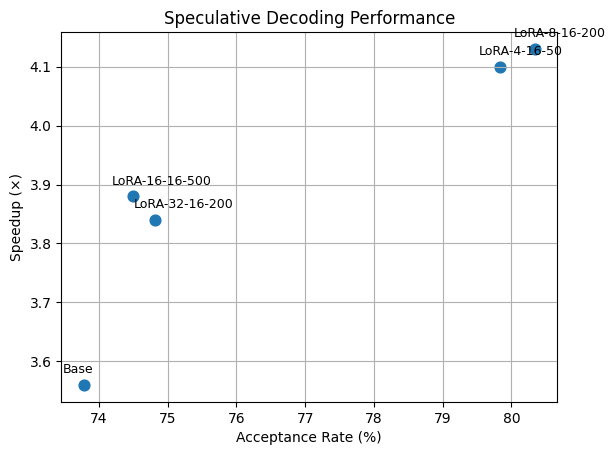

In [36]:
import matplotlib.pyplot as plt

models = ["Base", "LoRA-4-16-50", "LoRA-8-16-200","LoRA-16-16-500","LoRA-32-16-200"]
acceptance = [73.78, 79.83, 80.34, 74.49, 74.81]

speedup = [3.56,4.10, 4.13, 3.88, 3.84]

for i, name in enumerate(models):
    plt.text(acceptance[i] - 0.3, speedup[i] + 0.02, name, fontsize=9)

plt.scatter(acceptance, speedup, c='tab:blue', s=60)
plt.xlabel("Acceptance Rate (%)")
plt.ylabel("Speedup (×)")
plt.title("Speculative Decoding Performance")
plt.grid(True)
plt.show()

##

# Question 4. Advanced Part: Pruning (Bonus 10 pts)

## **Goal**

This **bonus** section is open-ended, inviting you to **explore and experiment creatively** with *model pruning* techniques aimed at improving draft model inference speed while preserving acceptable output quality. You are encouraged to apply any advanced pruning algorithms to the draft model to achieve speedup during speculative decoding.


You may explore **any pruning methods**, such as:
- **Token pruning** during decoding (e.g., remove low-importance tokens while keeping KV cache consistent)
- **Head or layer pruning** to skip redundant head or layers
- **Hybrid pruning** combining both of them or other pruning dimension

---

## **Requirements**

1. **Implement** at least one pruning strategy (token-level recommended).  
2. **Measure** both:
   - **Speedup** — latency reduction compared to the unpruned baseline  
   - **Quality retention** — output similarity, perplexity, or task accuracy  
3. **Document** your approach and results in a short report, including:
   - A brief description of the pruning method  
   - Quantitative results (speedup %, accuracy/perplexity drop %)  
   - Your analysis of trade-offs and stability  

An example is provided below to illustrate how **token pruning** can be applied to a standard LLM.



In [16]:
"""
Example: Simple Token Pruning Demo
----------------------------------
This demo shows how to prune only the most recent percentage of tokens before decoding.
It demonstrates a basic token-level pruning strategy to speed up inference
by reducing the number of tokens the model attends to.

Pruning logic:
--------------
- Keep only the last X% of tokens from the input sequence.
- Intuition: earlier tokens contribute less to predicting the next token.
- Benefit: reduces attention computation (O(n^2) -> O((n * keep_ratio)^2)).
- Trade-off: may slightly degrade coherence or factual consistency.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# === Load model and tokenizer ===
model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

# === Build a long prompt ===
prompt = "In this experiment, we explore how token pruning affects inference speed. " * 20
input_ids = tok(prompt, return_tensors="pt").to(model.device)

# === Token pruning logic ===
keep_ratio = 0.8  # Keep only the last 40% of tokens
n = input_ids.input_ids.shape[1]
keep_tokens = int(n * keep_ratio)

# We assume older tokens have diminishing effect, so we only keep the recent context.
pruned_input_ids = input_ids.input_ids[:, -keep_tokens:]
print(f"Original length: {n}, after pruning: {keep_tokens}")

# === Run inference ===
# The shorter context reduces prefill computation, leading to faster inference.
with torch.no_grad():
    outputs = model.generate(pruned_input_ids, max_new_tokens=50)

print(tok.decode(outputs[0], skip_special_tokens=True))

# === Suggested experiment ===
# Try varying keep_ratio = 0.2, 0.5, 0.8
# Measure:
#   - latency (e.g., using time.time())
#   - output coherence or task accuracy
# Compare with the full-prompt baseline to analyze speedup vs. quality trade-off.

Original length: 261, after pruning: 208
 this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed. In this experiment, we explore how token pruning affects inference speed.

In [22]:
import time
from datasets import load_dataset
from statistics import mean
import torch

model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

def evaluate_speedup_main_Prun(model,tok,keep_ratio,ds_name="openai_humaneval", ds_split="test[-20:]",gamma=5, max_new_tokens=128):
    """
    Evaluate speculative decoding vs target.generate() baseline
    to compute speedup ratio and acceptance rate.
    """
    global target_model, target_tok
    draft_model = model
    draft_tok = tok

    eval_ds = load_dataset(ds_name, split=ds_split)
    print(f"Loaded {len(eval_ds)} samples")

    base_times, spec_times, acc_rates, acc_rates_non = [], [], [],[]

    for i, ex in enumerate(eval_ds):
        prompt = ex["prompt"] if "prompt" in ex else ex.get("question", "")
        tokenized_non_prun = tok(prompt, return_tensors="pt").input_ids.to(target_model.device)

        input_ids = tok(prompt, return_tensors="pt").to(model.device)
        n = input_ids.input_ids.shape[1]
        keep_tokens = int(n * keep_ratio)
        tokenized = input_ids.input_ids[:, -keep_tokens:]

        print(f"\n[{i+1}/{len(eval_ds)}] Running speculative decoding with Non Prun...")
        t0 = time.time()
        _, acc_non = speculative_generate(tokenized_non_prun[0].tolist(), draft_model, target_model, target_tok, gamma=gamma)
        base_t = time.time() - t0

        print("Running speculative decoding with Prun...")
        t1 = time.time()
        _, acc = speculative_generate(tokenized[0].tolist(), draft_model, target_model, target_tok, gamma=gamma)
        spec_t = time.time() - t1

        base_times.append(base_t)
        spec_times.append(spec_t)
        acc_rates.append(acc)
        acc_rates_non.append(acc_non)
        print(f"  Non_prun: {base_t:.3f}s | Prun: {spec_t:.3f}s | speedup: {base_t/spec_t:.2f}× | acc ratio(prun/Non_prun): {acc/acc_non:.2%}")

    print("\n=== Summary ===")
    print(f"Avg target-only time : {mean(base_times):.3f}s")
    print(f"Avg speculative time : {mean(spec_times):.3f}s")
    print(f"Avg speedup ratio    : {mean([b/s for b, s in zip(base_times, spec_times)]):.2f}×")
    print(f"Avg acceptance ratio (prun vs non_prun)  : {mean([b/s for b, s in zip(acc_rates, acc_rates_non)]):.2%}")

if __name__ == "__main__":
  print("keep_ratio=0.8")
  evaluate_speedup_main_Prun(model=model,tok=tok,keep_ratio=0.8)
  print("keep_ratio=0.5")
  evaluate_speedup_main_Prun(model=model,tok=tok,keep_ratio=0.5)
  print("keep_ratio=0.2")
  evaluate_speedup_main_Prun(model=model,tok=tok,keep_ratio=0.2)

keep_ratio=0.8
Loaded 20 samples

[1/20] Running speculative decoding with Non Prun...
Running speculative decoding with Prun...
  Non_prun: 4.072s | Prun: 4.760s | speedup: 0.86× | acc ratio(prun/Non_prun): 70.86%

[2/20] Running speculative decoding with Non Prun...
Running speculative decoding with Prun...
  Non_prun: 3.707s | Prun: 4.231s | speedup: 0.88× | acc ratio(prun/Non_prun): 68.21%

[3/20] Running speculative decoding with Non Prun...
Running speculative decoding with Prun...
  Non_prun: 4.885s | Prun: 3.330s | speedup: 1.47× | acc ratio(prun/Non_prun): 147.62%

[4/20] Running speculative decoding with Non Prun...
Running speculative decoding with Prun...
  Non_prun: 4.934s | Prun: 3.860s | speedup: 1.28× | acc ratio(prun/Non_prun): 120.26%

[5/20] Running speculative decoding with Non Prun...
Running speculative decoding with Prun...
  Non_prun: 4.112s | Prun: 4.485s | speedup: 0.92× | acc ratio(prun/Non_prun): 82.03%

[6/20] Running speculative decoding with Non Prun...
R

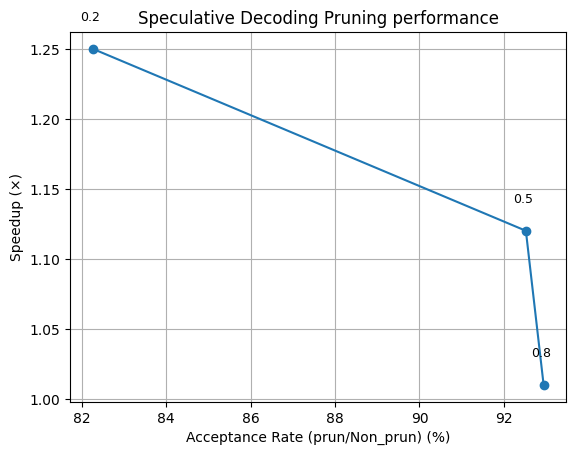

In [23]:
import matplotlib.pyplot as plt

models = ["0.8", "0.5", "0.2"]
acceptance = [92.94, 92.52, 82.26]
speedup = [1.01, 1.12, 1.25]

for i, name in enumerate(models):
    plt.text(acceptance[i] - 0.3, speedup[i] + 0.02, name, fontsize=9)

plt.plot(acceptance, speedup, marker='o')
plt.xlabel("Acceptance Rate (prun/Non_prun) (%)")
plt.ylabel("Speedup (×)")
plt.title("Speculative Decoding Pruning performance")
plt.grid(True)
plt.show()